# Importing Necessary Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Creating The Model

In [2]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            #Input: batch_size*channels_img*64*64
            nn.Conv2d(channels_img,features_d,kernel_size=4,stride=2,padding=1), #32*32
            nn.LeakyReLU(0.2),
            self.block(features_d,features_d*2,4,2,1), #16*16
            self.block(features_d*2,features_d*4,4,2,1), #8*8
            self.block(features_d*4,features_d*8,4,2,1), #4*4
            nn.Conv2d(features_d*8,1,kernel_size=4,stride=2,padding=0), #1*1
            nn.Sigmoid()
        )
    def block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),#we don't need bias as we are using batchnorm
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.disc(x)

#Generator
class Generator(nn.Module):
    def __init__(self,noise_dim,channels_img,features_g):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            #Input: batch_size*noise_dim*1*1
            self.block(noise_dim,features_g*16,4,1,0), #batch_size*f_g*16*4*4
            self.block(features_g*16,features_g*8,4,2,1), #batch_size*f_g*8*8*8
            self.block(features_g*8,features_g*4,4,2,1), #batch_size*f_g*4*16*16
            self.block(features_g*4,features_g*2,4,2,1), #batch_size*f_g*2*32*32
            nn.ConvTranspose2d(features_g*2,channels_img,kernel_size=4,stride=2,padding=1),#batch_size*channel_img*64*64
            nn.Tanh()
        )
    def block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),#we don't need bias as we are using batchnorm
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self,x):
        return self.gen(x)


# Initializing The Model Weights As Per The Paper

In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02) #0 mean and .02 std

# Hyperparameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4
noise_dim = 100
img_size = 64
batch_size = 128
num_epochs = 20
channels_img = 1
features_d = 64
features_g = 64

# Dataset MNIST

In [5]:
composed_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * channels_img, std=[0.5] * channels_img)
    ]
)
dataset = datasets.MNIST(root="dataset/",train=True,transform = composed_transforms, download=True)
dataloader = DataLoader(dataset,batch_size = batch_size,shuffle =True)

100%|██████████| 9912422/9912422 [00:00<00:00, 69053237.34it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 39113882.41it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20931874.69it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19761959.30it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# Initialization

In [6]:
gen = Generator(noise_dim,channels_img,features_g).to(device)
disc = Discriminator(channels_img,features_d).to(device)
initialize_weights(gen)
initialize_weights(disc)
opt_gen = optim.Adam(gen.parameters(),lr = lr,betas = (0.5,0.999))
opt_disc= optim.Adam(disc.parameters(),lr = lr,betas = (0.5,0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32,noise_dim,1,1).to(device)

Epoch 1/20: 100%|██████████| 469/469 [01:35<00:00,  4.91batch/s, D_loss=0.391, G_loss=2.07] 


Epoch [1/20], Avg Discriminator Loss: 0.3913, Avg Generator Loss: 2.0684


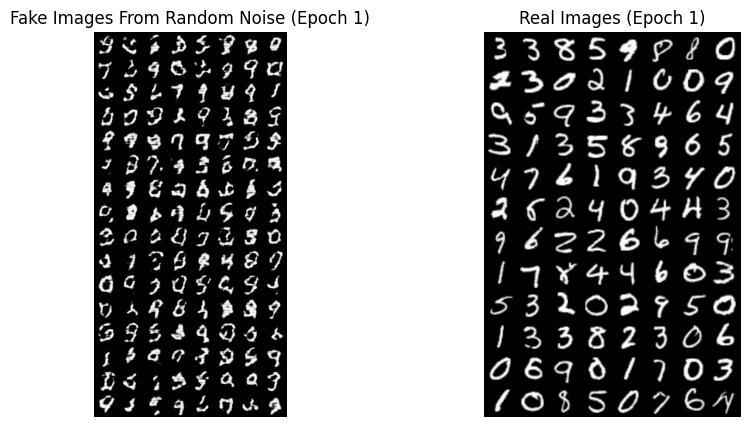

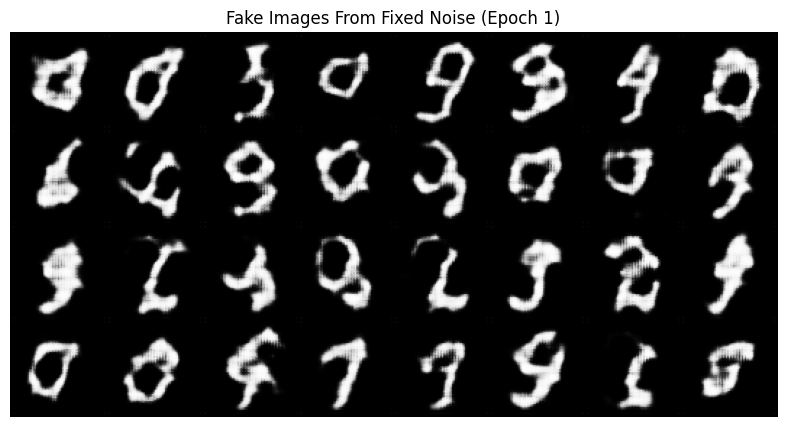

Epoch 2/20: 100%|██████████| 469/469 [01:34<00:00,  4.95batch/s, D_loss=0.588, G_loss=1.05] 


Epoch [2/20], Avg Discriminator Loss: 0.5882, Avg Generator Loss: 1.0506


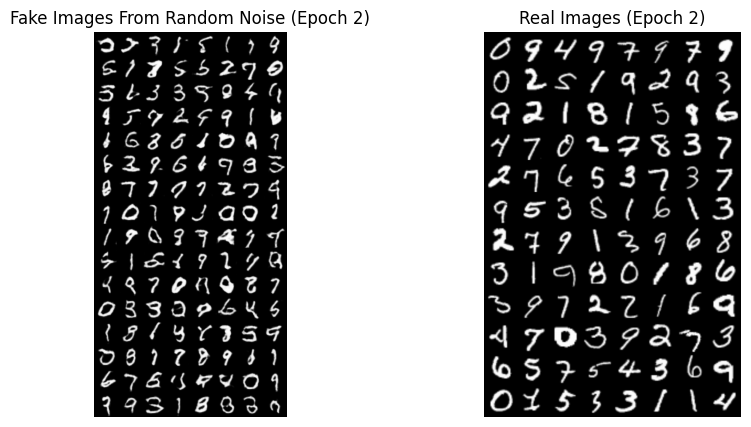

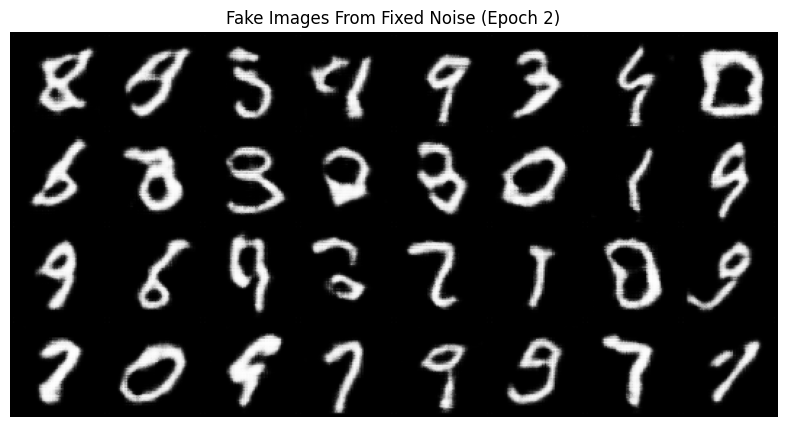

Epoch 3/20: 100%|██████████| 469/469 [01:34<00:00,  4.97batch/s, D_loss=0.451, G_loss=1.82]


Epoch [3/20], Avg Discriminator Loss: 0.4513, Avg Generator Loss: 1.8157


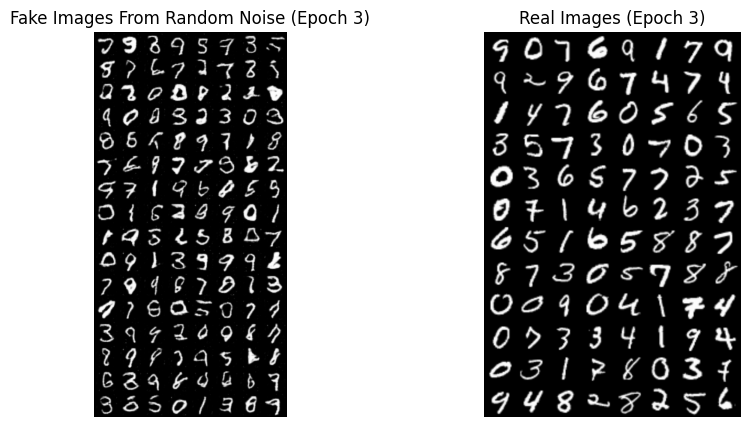

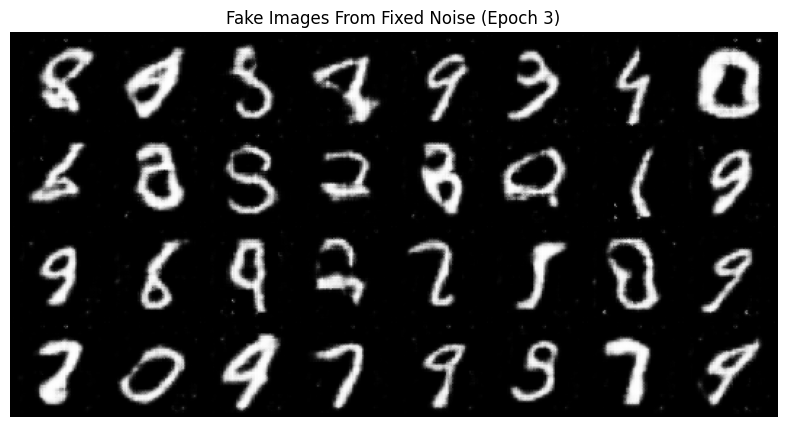

Epoch 4/20: 100%|██████████| 469/469 [01:34<00:00,  4.97batch/s, D_loss=0.308, G_loss=2.49]


Epoch [4/20], Avg Discriminator Loss: 0.3076, Avg Generator Loss: 2.4922


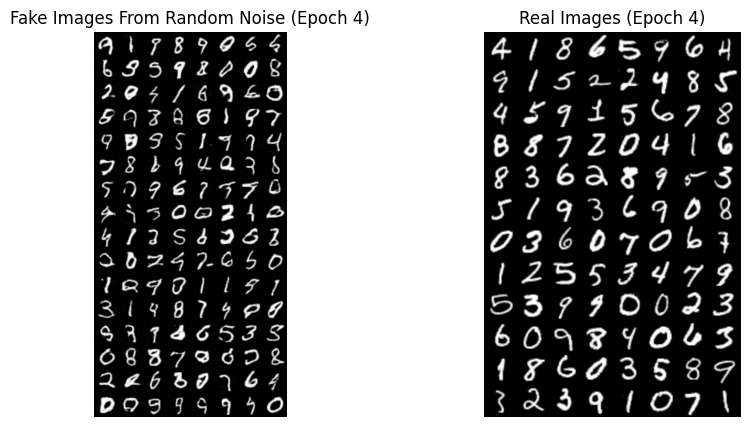

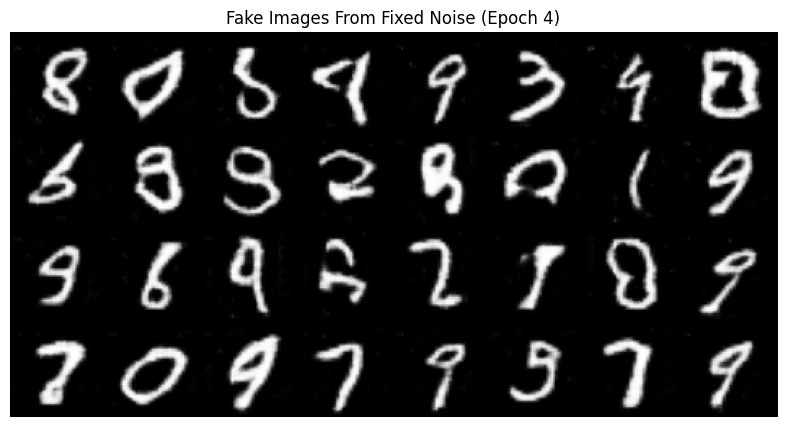

Epoch 5/20: 100%|██████████| 469/469 [01:34<00:00,  4.96batch/s, D_loss=0.261, G_loss=2.79]


Epoch [5/20], Avg Discriminator Loss: 0.2614, Avg Generator Loss: 2.7916


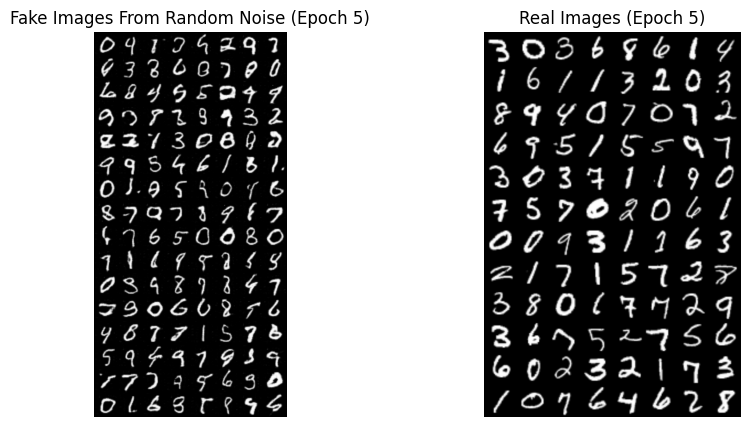

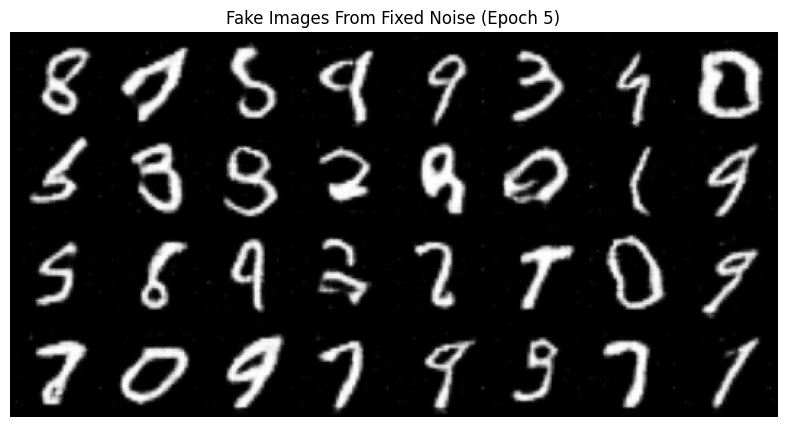

Epoch 7/20: 100%|██████████| 469/469 [01:34<00:00,  4.96batch/s, D_loss=0.231, G_loss=3.14]


Epoch [7/20], Avg Discriminator Loss: 0.2310, Avg Generator Loss: 3.1433


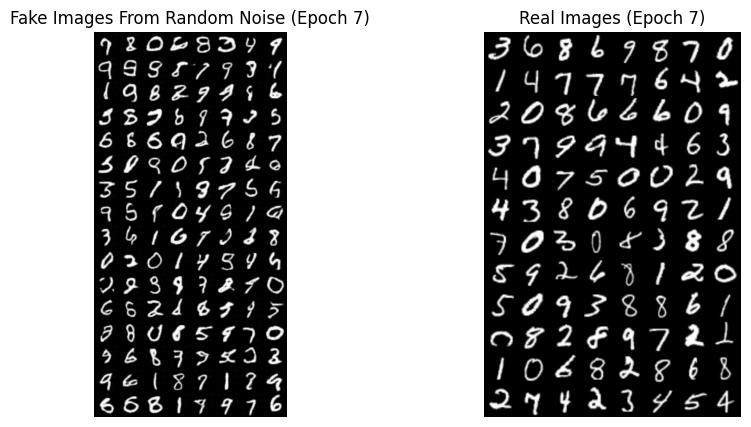

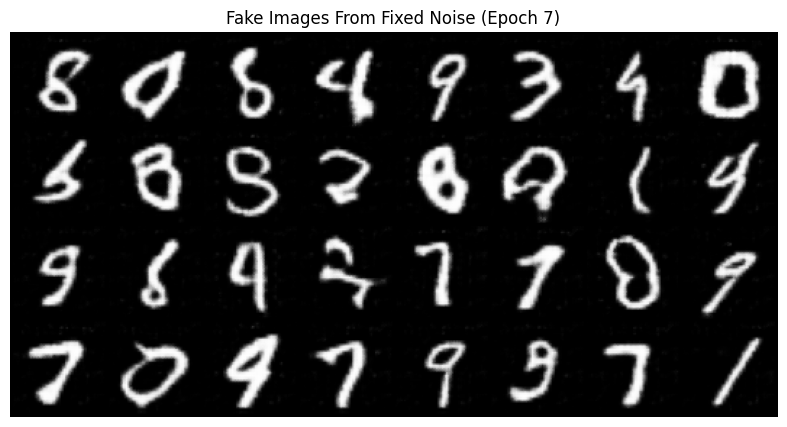

Epoch 8/20: 100%|██████████| 469/469 [01:34<00:00,  4.97batch/s, D_loss=0.256, G_loss=2.92]


Epoch [8/20], Avg Discriminator Loss: 0.2560, Avg Generator Loss: 2.9201


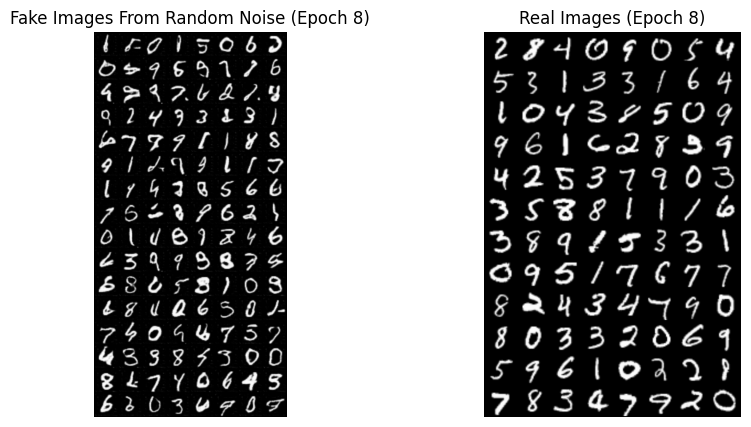

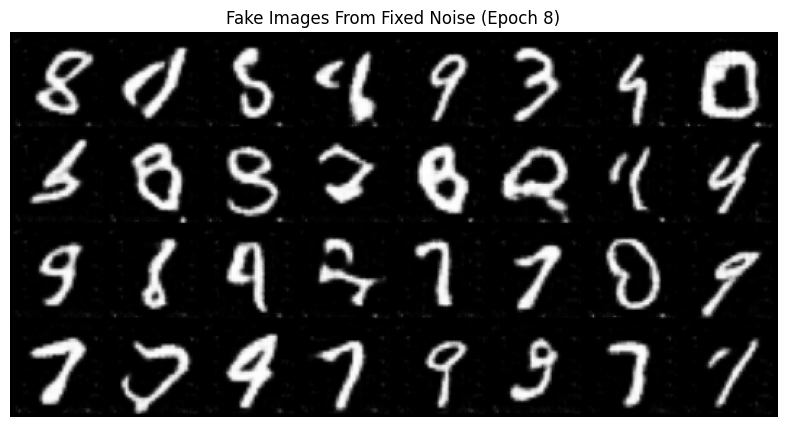

Epoch 9/20: 100%|██████████| 469/469 [01:34<00:00,  4.96batch/s, D_loss=0.186, G_loss=3.44]


Epoch [9/20], Avg Discriminator Loss: 0.1864, Avg Generator Loss: 3.4428


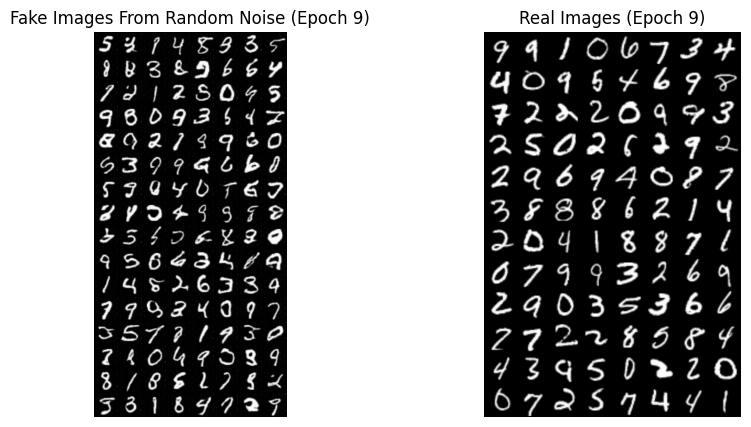

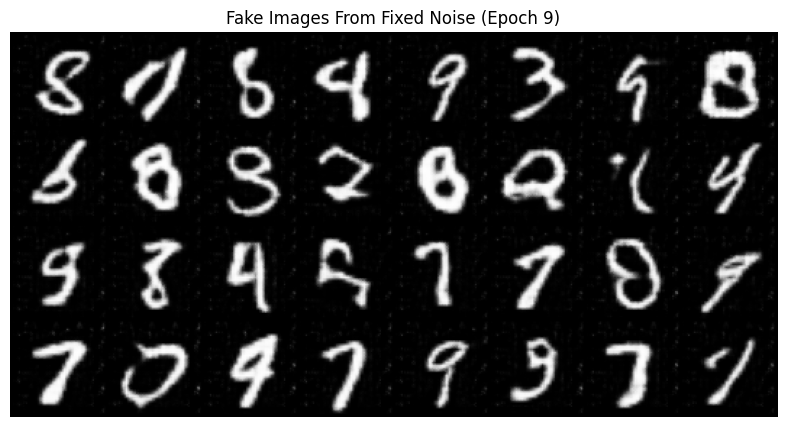

Epoch 10/20: 100%|██████████| 469/469 [01:34<00:00,  4.97batch/s, D_loss=0.262, G_loss=3.17]


Epoch [10/20], Avg Discriminator Loss: 0.2625, Avg Generator Loss: 3.1700


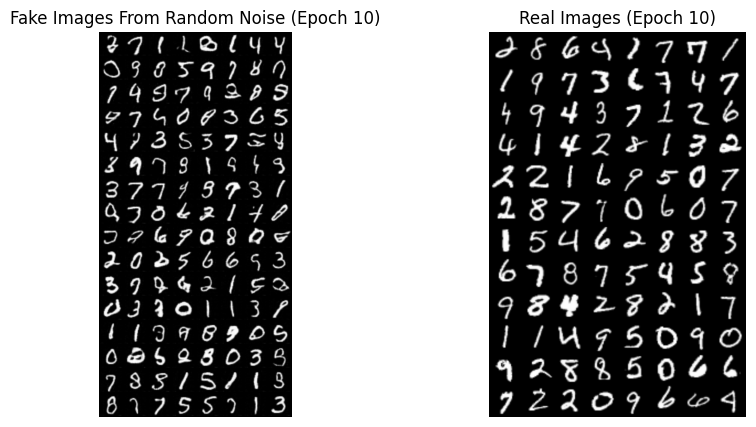

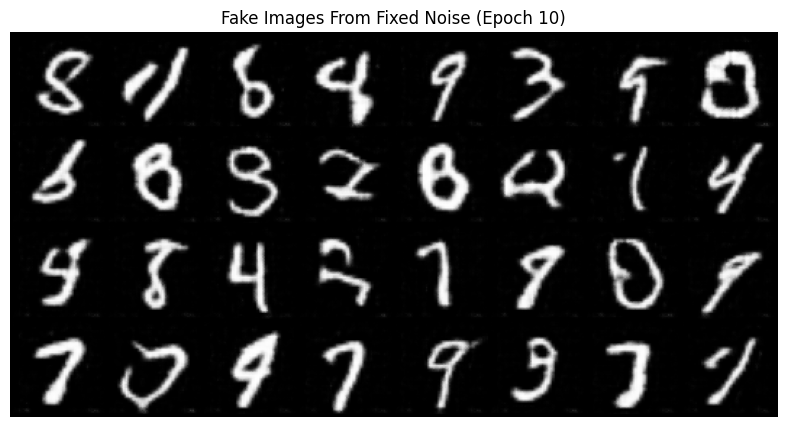

Epoch 11/20: 100%|██████████| 469/469 [01:34<00:00,  4.97batch/s, D_loss=0.187, G_loss=3.58]


Epoch [11/20], Avg Discriminator Loss: 0.1870, Avg Generator Loss: 3.5847


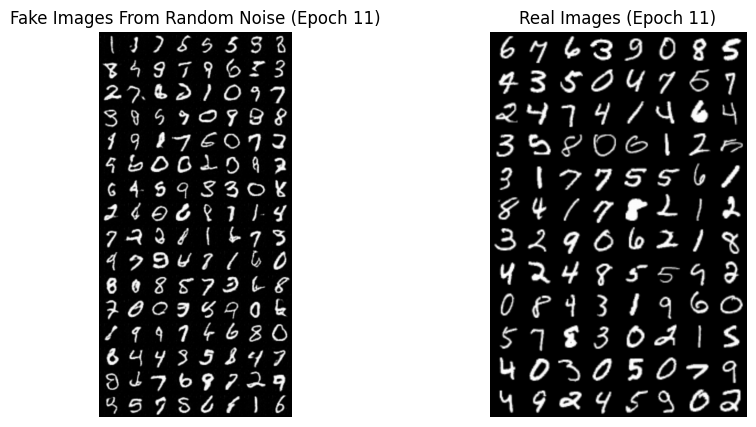

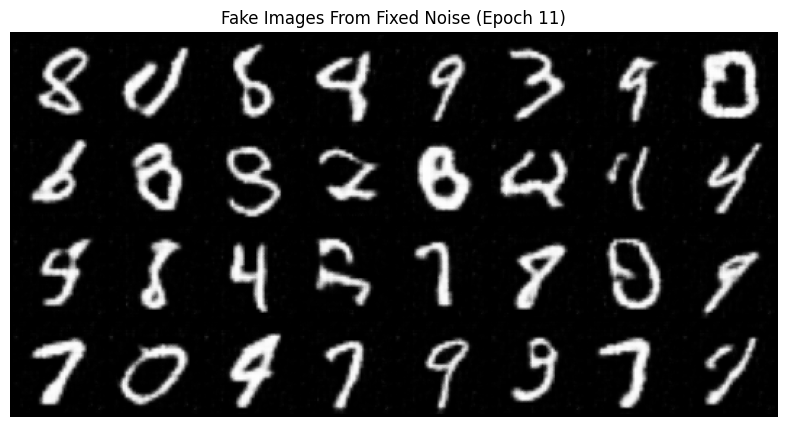

Epoch 12/20: 100%|██████████| 469/469 [01:34<00:00,  4.99batch/s, D_loss=0.205, G_loss=3.49]


Epoch [12/20], Avg Discriminator Loss: 0.2055, Avg Generator Loss: 3.4850


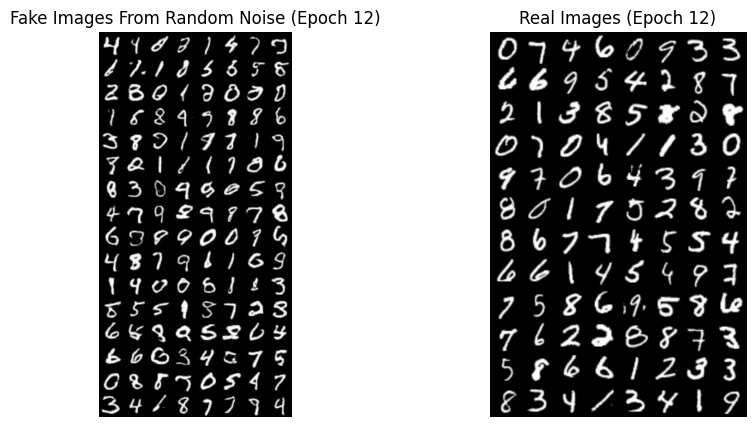

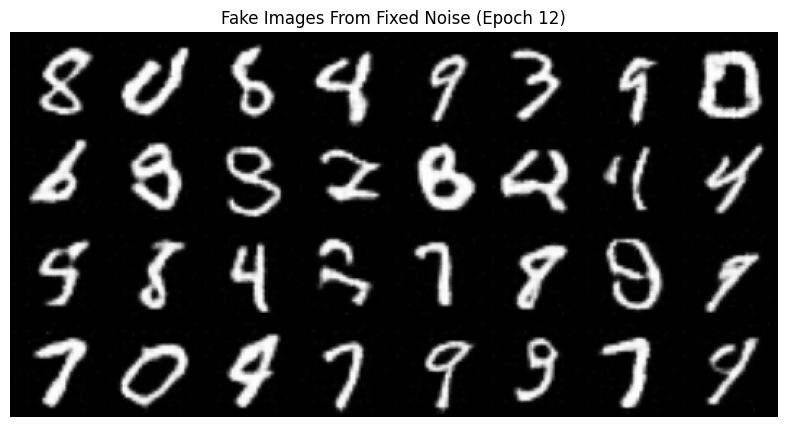

Epoch 13/20: 100%|██████████| 469/469 [01:34<00:00,  4.98batch/s, D_loss=0.191, G_loss=3.58]


Epoch [13/20], Avg Discriminator Loss: 0.1911, Avg Generator Loss: 3.5780


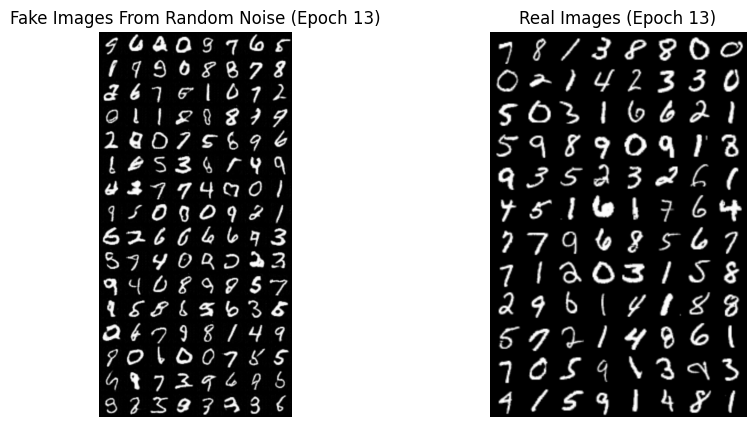

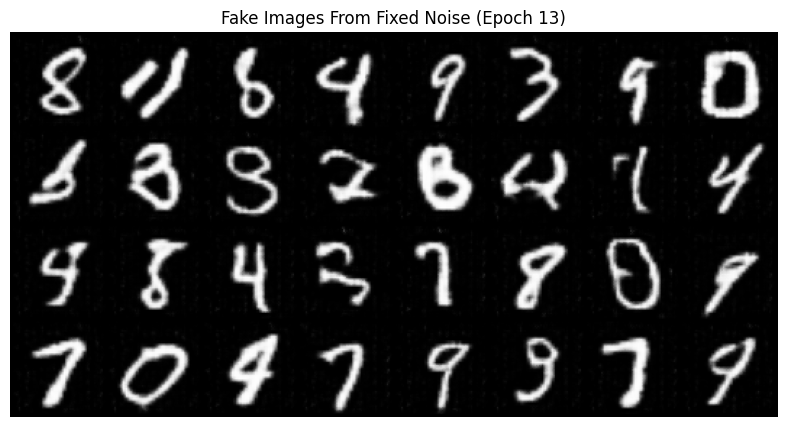

Epoch 14/20: 100%|██████████| 469/469 [01:34<00:00,  4.96batch/s, D_loss=0.232, G_loss=3.43] 


Epoch [14/20], Avg Discriminator Loss: 0.2318, Avg Generator Loss: 3.4317


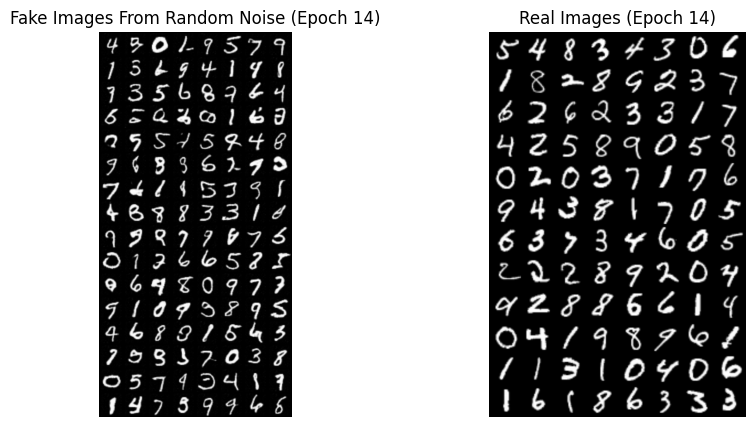

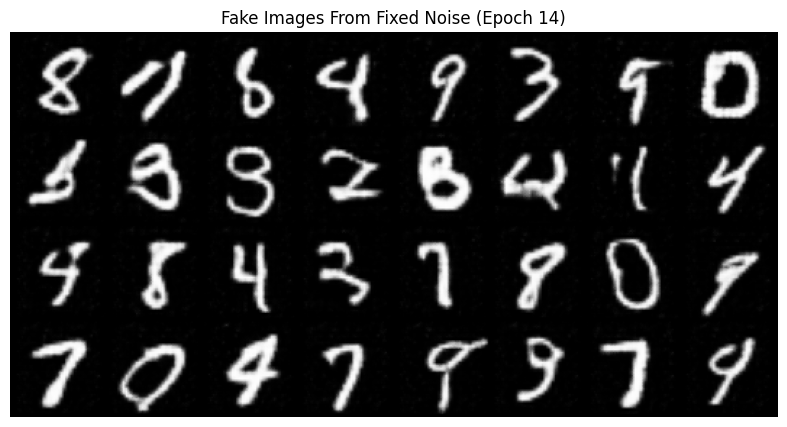

Epoch 15/20: 100%|██████████| 469/469 [01:34<00:00,  4.97batch/s, D_loss=0.258, G_loss=3.21]


Epoch [15/20], Avg Discriminator Loss: 0.2576, Avg Generator Loss: 3.2105


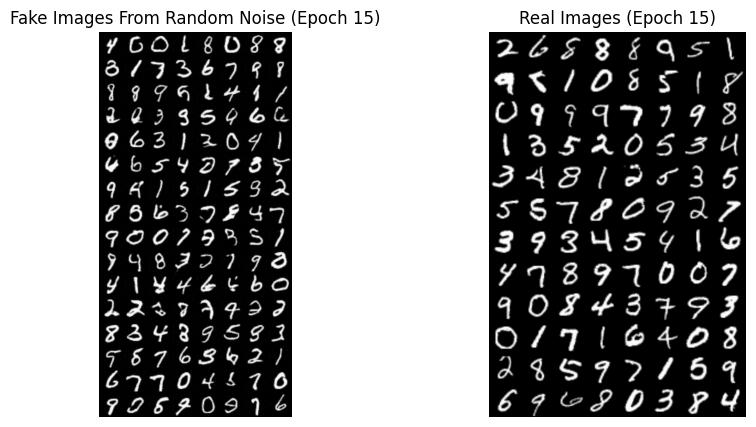

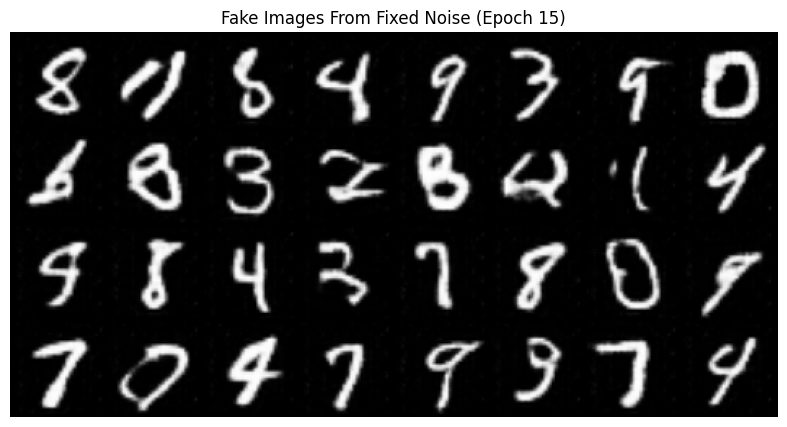

Epoch 16/20: 100%|██████████| 469/469 [01:34<00:00,  4.97batch/s, D_loss=0.177, G_loss=3.82] 


Epoch [16/20], Avg Discriminator Loss: 0.1774, Avg Generator Loss: 3.8248


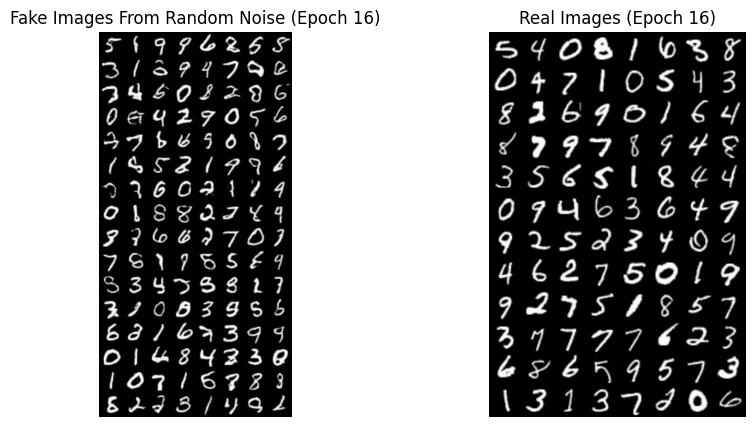

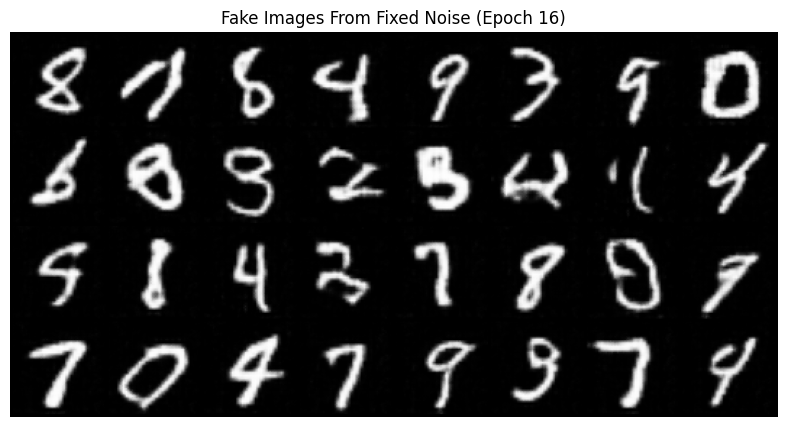

Epoch 17/20: 100%|██████████| 469/469 [01:33<00:00,  5.00batch/s, D_loss=0.192, G_loss=3.57] 


Epoch [17/20], Avg Discriminator Loss: 0.1925, Avg Generator Loss: 3.5731


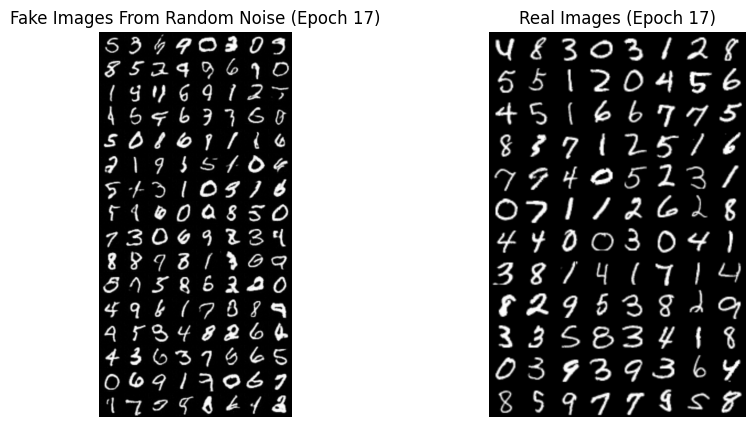

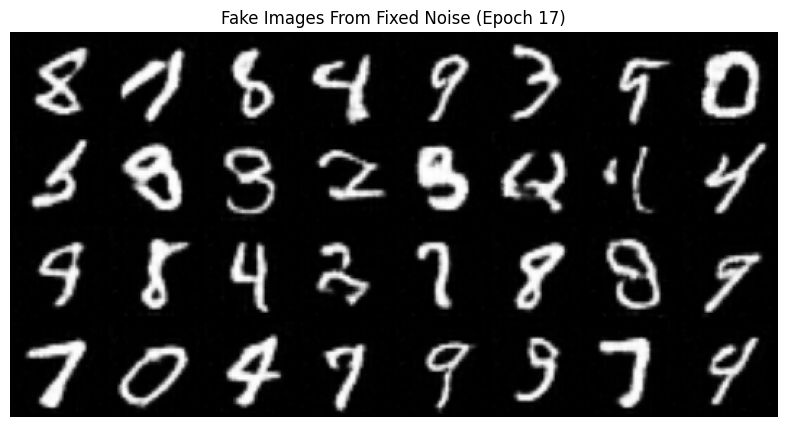

Epoch 18/20: 100%|██████████| 469/469 [01:33<00:00,  5.00batch/s, D_loss=0.183, G_loss=3.81]


Epoch [18/20], Avg Discriminator Loss: 0.1832, Avg Generator Loss: 3.8125


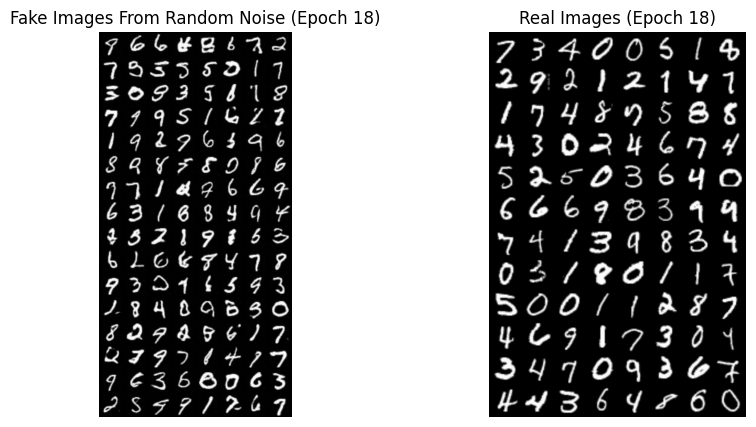

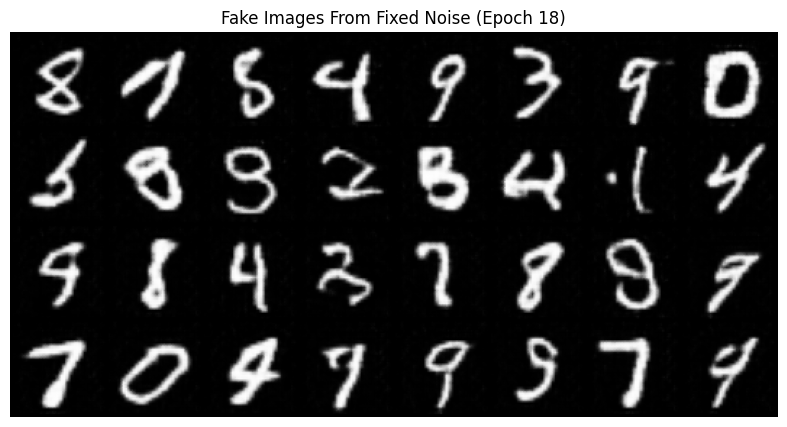

Epoch 19/20: 100%|██████████| 469/469 [01:34<00:00,  4.98batch/s, D_loss=0.204, G_loss=3.55]


Epoch [19/20], Avg Discriminator Loss: 0.2041, Avg Generator Loss: 3.5482


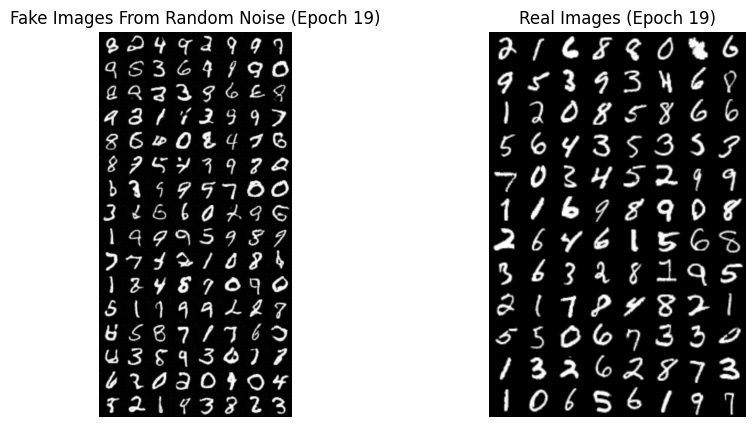

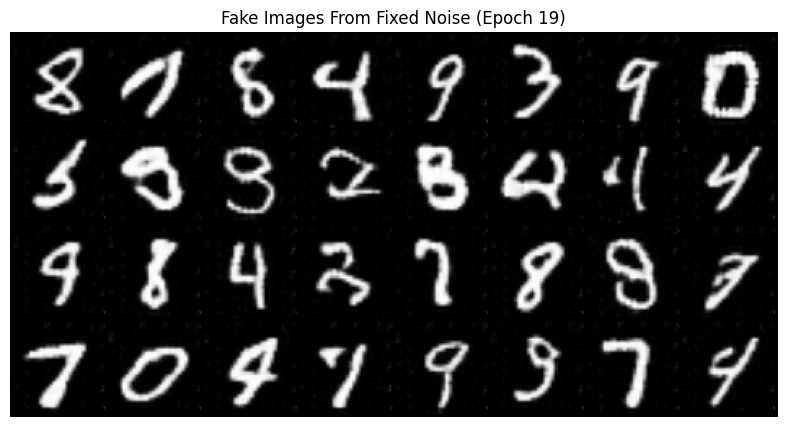

Epoch 20/20: 100%|██████████| 469/469 [01:34<00:00,  4.97batch/s, D_loss=0.24, G_loss=3.46]  


Epoch [20/20], Avg Discriminator Loss: 0.2404, Avg Generator Loss: 3.4614


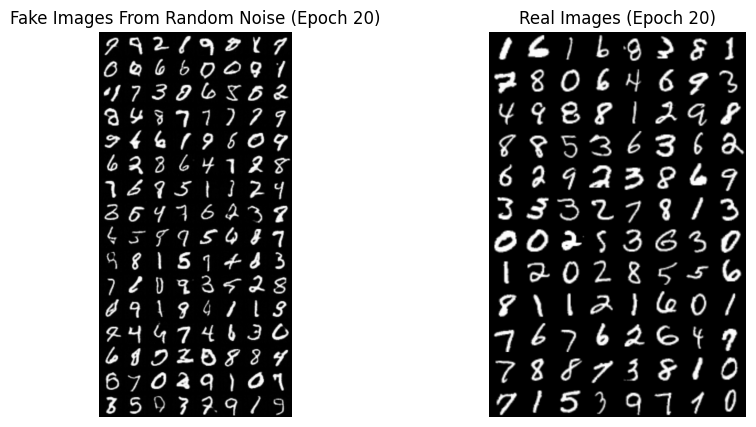

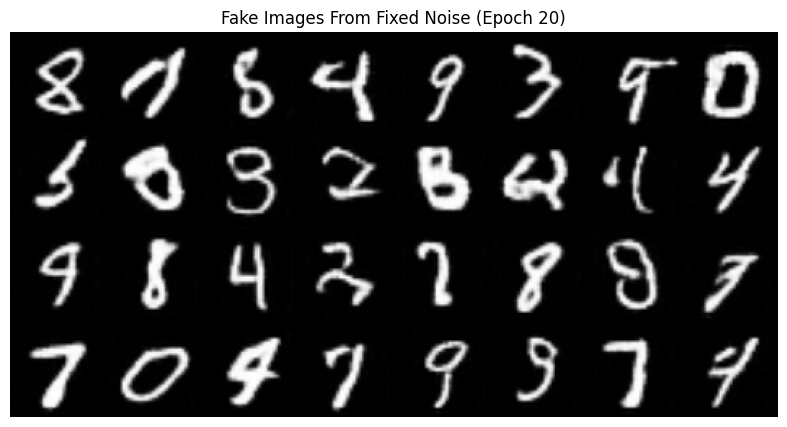

In [7]:
# %%time
output_dir = "/kaggle/working/images"
# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
gen_loss = []
disc_loss = []
gen.train()
disc.train()
for epoch in range(num_epochs):
    total_lossD = 0.0
    total_lossG = 0.0
    
    # Create tqdm progress bar
    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as t:
        for batch_idx, (real_img, label) in t:
            real_img = real_img.to(device)  
            noise = torch.randn(batch_size, noise_dim,1,1).to(device)
            fake_img = gen(noise)
        
            #Train Discriminator : loss = max (log(D(real)) + log(1-D(G(noise)))) === min(-(log(D(real)) + log(1-D(G(noise)))))
            disc_real = disc(real_img).view(-1) #to flatten from [32,1] to [32]
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake_img).view(-1)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2
            opt_disc.zero_grad()
            lossD.backward(retain_graph=True)#to use the fake_img , otherwise it will be cleared out during back propagation
            opt_disc.step()
            
            #Train Generator: loss = min log(1-D(G(z))) --->gives us weak gradients,not so good for training -> max(log(D(G(z)))) === min(-log(D(G(z))))
            output = disc(fake_img).view(-1)
            lossG = criterion(output, torch.ones_like(output))
            opt_gen.zero_grad()
            lossG.backward()
            opt_gen.step()
            
            # Accumulate losses
            total_lossD += lossD.item()
            total_lossG += lossG.item()
            
            # Update tqdm description with current losses
            t.set_postfix({'D_loss': total_lossD / (batch_idx + 1), 'G_loss': total_lossG / (batch_idx + 1)})
        
    # Compute average losses for the epoch
    avg_lossD = total_lossD / len(dataloader)
    avg_lossG = total_lossG / len(dataloader)
    disc_loss.append(avg_lossD)
    gen_loss.append(avg_lossG)

    # Print discriminator and generator average losses for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Discriminator Loss: {avg_lossD:.4f}, Avg Generator Loss: {avg_lossG:.4f}")
    
    #Visualization With Tensorboard
    with torch.no_grad():
        fake_vid = gen(fixed_noise).reshape(-1,1,64,64)
        fake = fake_img.reshape(-1,1,64,64)
        data = real_img.reshape(-1,1,64,64)
        img_grid_fake_vid = torchvision.utils.make_grid(fake_vid,normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake,normalize=True)
        img_grid_real = torchvision.utils.make_grid(data,normalize=True)
        
        plt.figure(figsize=(10, 5))

        # Plotting the fake images
        plt.subplot(1, 2, 1)
        plt.imshow(torchvision.utils.make_grid(img_grid_fake.cpu(), normalize=True).permute(1, 2, 0))
        plt.title(f"Fake Images From Random Noise (Epoch {epoch+1})")
        plt.axis('off')

        # Plotting the real images
        plt.subplot(1, 2, 2)
        plt.imshow(torchvision.utils.make_grid(img_grid_real.cpu(), normalize=True).permute(1, 2, 0))
        plt.title(f"Real Images (Epoch {epoch+1})")
        plt.axis('off')
        
        # Storing the fake images generated from fixed noise
        plt.figure(figsize=(10, 5))
        plt.imshow(torchvision.utils.make_grid(img_grid_fake_vid.cpu(), normalize=True).permute(1, 2, 0))
        plt.title(f"Fake Images From Fixed Noise (Epoch {epoch+1})")
        plt.axis('off')
        # Save the image
        plt.savefig(os.path.join(output_dir, f"epoch_{epoch+1}.png"))
        
        plt.show()

# Plotting Losses

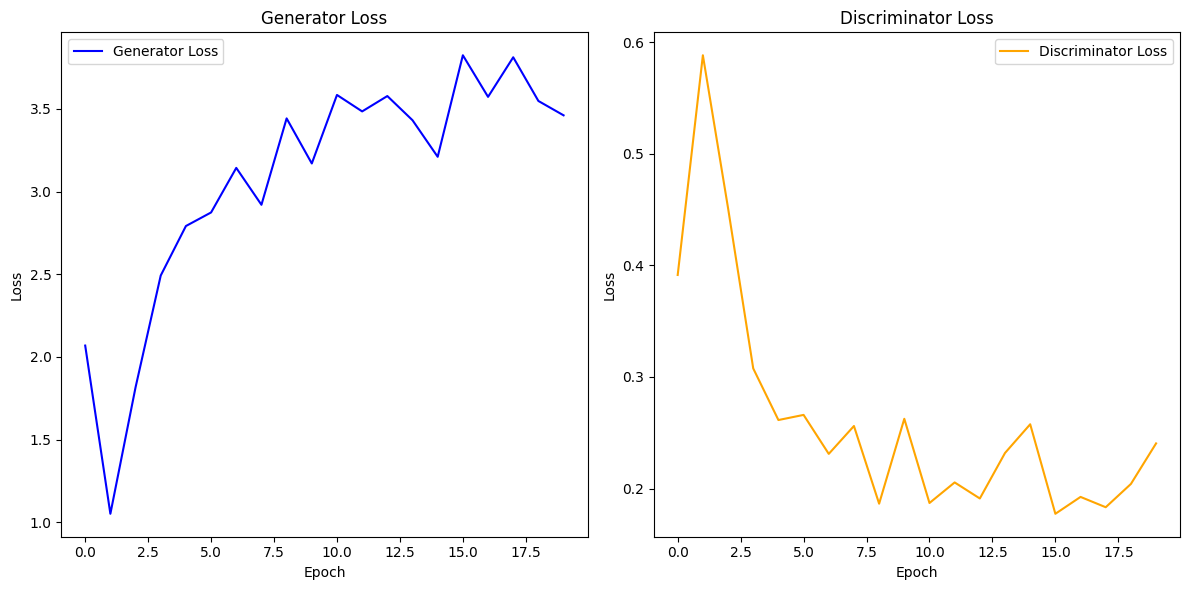

In [8]:
plt.figure(figsize=(12, 6))

# Plotting generator loss
plt.subplot(1, 2, 1)
plt.plot(gen_loss, label='Generator Loss', color='blue')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting discriminator loss
plt.subplot(1, 2, 2)
plt.plot(disc_loss, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Converting Generated Images from Fixed Noise to Video

In [10]:
# Convert images to video
import cv2
import glob

image_files = ['/kaggle/working/images/epoch_1.png',
 '/kaggle/working/images/epoch_2.png',
 '/kaggle/working/images/epoch_3.png',
 '/kaggle/working/images/epoch_4.png',
 '/kaggle/working/images/epoch_5.png',
 '/kaggle/working/images/epoch_6.png',
 '/kaggle/working/images/epoch_7.png',
 '/kaggle/working/images/epoch_8.png',
 '/kaggle/working/images/epoch_9.png',
 '/kaggle/working/images/epoch_10.png',
 '/kaggle/working/images/epoch_11.png',
 '/kaggle/working/images/epoch_12.png',
 '/kaggle/working/images/epoch_13.png',
 '/kaggle/working/images/epoch_14.png',
 '/kaggle/working/images/epoch_15.png',
 '/kaggle/working/images/epoch_16.png',
 '/kaggle/working/images/epoch_17.png',
 '/kaggle/working/images/epoch_18.png',
 '/kaggle/working/images/epoch_19.png',
 '/kaggle/working/images/epoch_20.png',
]

frame = cv2.imread(image_files[0])
height, width, layers = frame.shape

video_name = 'generated_images.avi'
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 2, (width, height)) #2->fps

for image_file in image_files:
    video.write(cv2.imread(image_file))

video.release()

print(f"Video saved as {video_name}")

Video saved as generated_images.avi
